In [3]:
#Factor Analyser
#Load data
import glob 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from numpy.linalg import inv
import math
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_curve, roc_auc_score

#Load Data 
def load_images(file_path):
    imgs_flat = []
    for file in glob.glob(file_path): 
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#       hist = cv2.equalizeHist(gray_img)
        gray = cv2.resize(gray_img,(10,10))
        img_flat = gray.ravel()
        imgs_flat.append(img_flat) 
    return np.array(imgs_flat)

def calculate_gaussian_pdf(data, mu, sig):
	sig_inv = np.linalg.inv(sig)
	det = np.linalg.det(sig)
	temp = data-mu
	term = np.matmul(np.matmul(temp,sig_inv), temp.T)
	exp_term = math.exp(-0.5*term)
	pdf = exp_term/math.sqrt(det) 
	return pdf

## Load Training Data 
positive_train = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Positive\\*.jpg")
negative_train = load_images('H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Negative\\*.jpg')
##Load Testing Data
test_pos_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Positive\\*.jpg")
test_neg_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Negative\\*.jpg")

In [4]:
## Factor Analyser - EM Algorithm
def calc_Ehi(phi,sigma, I, x_mu_diff):
    temp = la.pinv(np.matmul(np.matmul(phi.T,la.pinv(sigma)),phi) + I) 
    Ehi = np.matmul(temp,np.matmul(np.matmul(phi.T,la.pinv(sigma)),x_mu_diff.T)) 
    Ehi_hi_T = np.matmul(Ehi,Ehi.T) + temp
    return Ehi, Ehi_hi_T

def EM(x, N):  
    m,n = x.shape
    #Initialize
    mu = x.mean(axis=0)
    x_mu_diff = x-mu
    phi = np.random.normal(size = (n,N))
    sigma = np.cov(x,rowvar = False)
    I = np.eye(N)
    prev_log = -np.inf
    
    while True:
        # E step
        (Ehi,Ehi_hi_T) = calc_Ehi(phi,sigma, I, x_mu_diff)
        # M step
        x_Ehi = np.matmul(x_mu_diff.T,Ehi.T)
        phi = np.matmul(x_Ehi,la.pinv(Ehi_hi_T))
        temp1 = np.matmul(x_mu_diff.T,x_mu_diff)
        temp2 = np.matmul(phi,np.matmul(Ehi,x_mu_diff))
        sigma = (temp1-temp2)/m

        temp3 = 0
        current_log = 0 
        current_sigma = np.matmul(phi,phi.T) + sigma
        # Log likelihood
        for i in range(m):
            temp3 += multivariate_normal.pdf(x[i], mu, current_sigma)
            current_log += np.log(temp3)
        if np.abs(current_log - prev_log) < 0.01:
            break
        print(str(current_log))
        prev_log = current_log
    return mu,sigma,phi

In [5]:
##Calculate Predictions
pred = []
def calc_predictions(test_img, mu_pos, sig_pos, phi_pos, mu_neg, sig_neg, phi_neg):
    for test in test_img:
        pos_cov = (np.matmul(phi_pos,phi_pos.T)) + sig_pos
        neg_cov = (np.matmul(phi_neg,phi_neg.T)) + sig_neg
        face_pdf = multivariate_normal.pdf(test, mu_pos, pos_cov)
        non_face_pdf = multivariate_normal.pdf(test, mu_neg, neg_cov)
        posterior = (face_pdf)/(non_face_pdf+face_pdf)
        pred.append(posterior)
    return pred

##Evaluation of Learned model Performance
def print_result(accuracy, false_postive_rate, false_negative_rate, misclass):
    print("\nResults: ")
    print("----------")
    print("Accuracy: "+str(accuracy))
    print("False positive rate: "+str(false_postive_rate/100))
    print("False negative rate: "+str(false_negative_rate/100))
    print("Misclassification rate: "+str(misclass))
    
def calc_accuracy(probability_pred, original):
    probability_pred = [ round(elem,2) for elem in probability_pred ]
    predictions = []
    for i in probability_pred:
        if i > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    match_count = 0
    for x,y in zip(original, predictions):
        if x==y:
            match_count+=1
    accuracy = match_count/len(predictions)
    misclass = 1-accuracy
    false_postive_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==1:
            false_postive_rate +=1    
    false_negative_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==0:
            false_negative_rate+=1 
    print_result(accuracy, false_postive_rate, false_negative_rate, misclass)  
    return probability_pred

In [6]:
## Mean and Covarince Visualization

def mean_visualize(mean, path):
    mean_image = np.array(mean,dtype="uint8").reshape(10,10,1)
    mean_image = cv2.resize(mean_image, (60,60))
    cv2.imwrite(path,mean_image)

def cov_visualize(cov, path):
    covar_diag = np.rint(np.diag(cov))
    covar_diag = np.rint(255 * covar_diag / max(covar_diag))
    covar_array = np.array(covar_diag, dtype='uint8')
    covar_image = covar_array.reshape(10,10)
    covar_image = cv2.resize(covar_image, (60,60))
    cv2.imwrite(path,covar_image)


In [7]:
[mu_pos, sig_pos, phi_pos]= EM(positive_train, 50)
[mu_neg, sig_neg, phi_neg]= EM(negative_train, 50)
## Prediction and Evaluation
#Test data - Faces
original_pos = [1]*100
calc_predictions(test_pos_img, mu_pos, sig_pos, phi_pos, mu_neg, sig_neg, phi_neg)

#Test data - Non Faces
original_neg = [0]*100
calc_predictions(test_neg_img, mu_pos, sig_pos, phi_pos, mu_neg, sig_neg, phi_neg)
original = original_pos + original_neg
probability_pred = calc_accuracy(pred, original)

-511169.302023
-511190.106339
-511190.127134
-425127.743067
-425144.663039
-425144.679953

Results: 
----------
Accuracy: 0.905
False positive rate: 0.05
False negative rate: 0.14
Misclassification rate: 0.09499999999999997


In [8]:
##Plot ROC curve
def plot_ROC(original, predictions):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(original, predictions)
    roc_auc = roc_auc_score(original,predictions)
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.show()

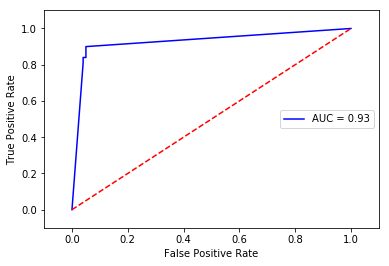

In [9]:
## Visualize - Estimated mean(s) and covariance matrix for face and non-face
mean_visualize(mu_pos, "H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model5\\Model5_mean_pos.jpg")
mean_visualize(mu_neg, "H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model5\\Model5_mean_neg.jpg")
cov_visualize(sig_pos, "H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model5\\Model5_cov_pos.jpg")
cov_visualize(sig_neg,"H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model5\\Model5_cov_neg.jpg")

plot_ROC(original,probability_pred)

In [29]:
predicted_prob

[1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.01,
 1.0,
 1.0,
 1.0,
 0.98999999999999999,
 1.0,
 0.98999999999999999,
 1.0,
 1.0,
 1.0,
 1.0,
 0.93000000000000005,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.93000000000000005,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96999999999999997,
 1.0,
 1.0,
 1.0,
 1.0,
 0.93000000000000005,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.97999999999999998,
 0.0,
 0.0,
 0.0,
 0.93999999999999995,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 